In [258]:
#configure notebook
import warnings
warnings.filterwarnings('ignore')

#import packages
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
#from lmfit import Model
#from lmfit import Parameters
%matplotlib inline

from statistics import mean
import scipy
from pathlib import Path
from operator import truediv

# Measurement Characterization and Filepaths

In [34]:
#choose filepath to desired data
path = '/Volumes/KESU/image_data/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [35]:
waves= np.linspace(7,12,61)

In [36]:
#select ROI
ymin2 = 105; ymax2 = 135;
ymin1 = 140; ymax1 = 170;

FOV = 53.51 ;
HFOV = 5;
view_angle = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

# Load NUC and determine DFC

In [331]:
'''LOAD slope from 2 point NUC'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC.h5" 

hf = h5py.File(save_path+name, 'r')
M1 = hf.get('M1')
M2 = hf.get('M2')
T1 = hf.get('Tref1')
T2 = hf.get('Tref2')
ROI1 = hf.get('ROI1')
ROI2 = hf.get('ROI2')

## Check NUC

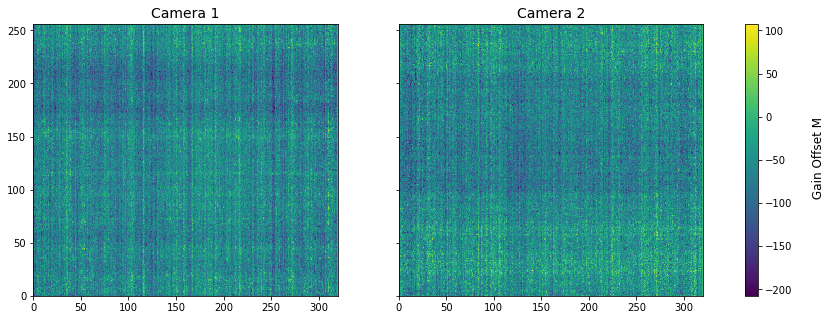

In [332]:
#plot DFCs, check appearance 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(M1,shading = 'auto')
axes[0].set_title('Camera 1',fontsize = 14)

p2 = axes[1].pcolormesh(M2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
cbar = fig.colorbar(p2, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Gain Offset M',fontsize = 12)

plt.show()

In [333]:
#first, determine reference temp for each camera
ref_name  = '70C.h5'
dark_name = 'dark.h5'
pn = '/Volumes/KESU/mar26/'

tref1, tref2 = determine_reference(pn,ref_name )

'''determine DFC'''
df_dark = create_LUT_df(pn,dark_name)
df_ref = create_LUT_df(pn,ref_name)
tref1,tref2,D1,D2 = determine_dark(df_dark,df_ref,0,0)

Ref T1 is 33.4
Ref T2 is 34.1


### Check appearance of DFCs

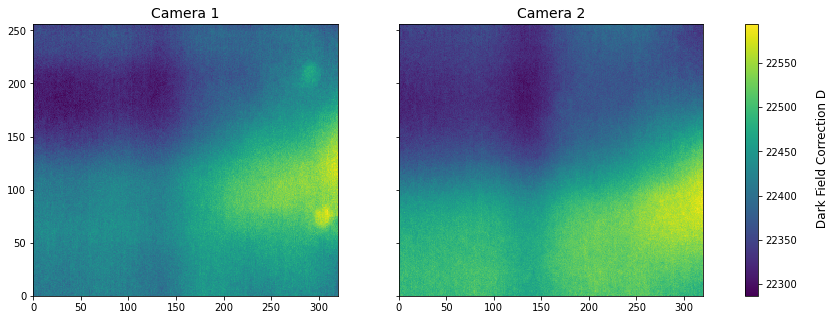

In [334]:
#plot DFCs, check appearance 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(D1,shading = 'auto')
axes[0].set_title('Camera 1',fontsize = 14)

p2 = axes[1].pcolormesh(D2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Dark Field Correction D',fontsize = 12)

plt.show()

### Check an intermediate image

In [328]:
def rc(r,T,m,b,T_ref):
    ''''this is the NUC correction function'''
    return(r + m*(T_ref-T) - b)


array([[22831.7, 22833. , 22815.4, ..., 22877.8, 22868.3, 22887.1],
       [22828.8, 22823.3, 22826.3, ..., 22871.1, 22881.8, 22876.2],
       [22829.3, 22830.2, 22820. , ..., 22896.6, 22865.9, 22869.1],
       ...,
       [22846.3, 22835.8, 22826.8, ..., 22889.6, 22880.1, 22866.3],
       [22830.9, 22840. , 22837.4, ..., 22893.3, 22892.2, 22890.2],
       [22823.5, 22838.2, 22839.2, ..., 22896.3, 22882.3, 22871.6]])

-1.5
-2.1000000000000014


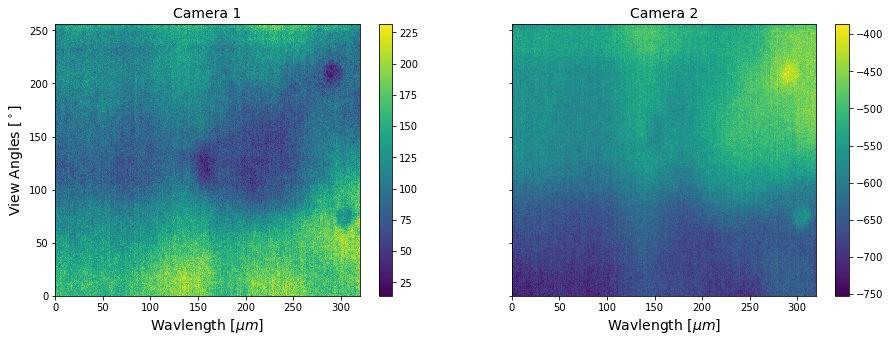

In [339]:
filename = path + 'Capture'+str(1500)+'.hdf5'

with h5py.File(filename, "r") as file:
     image1 = np.mean(file['image1'][()],axis = 0)
     image2 = np.mean(file['image2'][()],axis = 0)
     t1 = np.mean(file['temp1'][()])
     t2 = np.mean(file['temp2'][()])

c1 = rc(image1 ,t1,-.1, D1,tref1)
print(t1-tref1)
print(t2-tref2)

c2 = rc(image2 ,t2,-1, D2,tref2)
#c2[c2 <= 0] = 0

#plot test images, test appearance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

p1 = axes[0].pcolormesh(c1,shading = 'auto')
fig.colorbar(p1, ax=axes[0])
axes[0].set_title('Camera 1',fontsize = 14)
axes[0].set_ylabel('View Angles [$^\circ$]',fontsize = 14)
axes[0].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)

p2 = axes[1].pcolormesh(c2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
axes[1].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)
fig.colorbar(p2, ax=axes[1])

plt.show()


In [292]:
def importCapture(index,x,y):
    filename = path + 'Capture'+str(index)+'.hdf5'
    try:
        with h5py.File(filename, "r") as file:
             r1 = np.mean(file['image1'][()], axis = 0)
             r2 = np.mean(file['image2'][()], axis = 0)
             t1 = np.mean(file['temp1'][()])
             t2 = np.mean(file['temp2'][()])
             return(t1,t2,r1[y,x],r2[y,x])
    except:
        print(i)
        return(0,0,0,0)
        
    

In [319]:
start = 1366
stop  = 2630
y = 175
x = 125
t1 =  np.zeros(stop-start)
t2 = np.zeros(stop-start) 
r1 =  np.zeros(stop-start)
r2 = np.zeros(stop-start)
for i in range(start,stop):
    t1[i-start],t2[i-start],r1[i-start],r2[i-start] = importCapture(i,y,x)

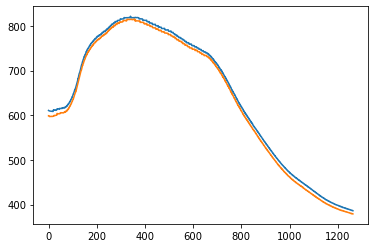

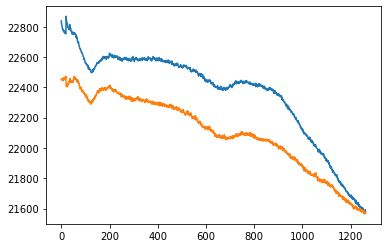

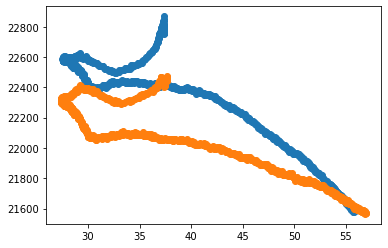

In [320]:
plt.plot(list(map(truediv, r1,t1)))
plt.plot(list(map(truediv, r2,t2)))
plt.show()

plt.plot(r1[:-1])
plt.plot(r2[:-1])

plt.show()

plt.scatter(t1[:-1],r1[:-1])
plt.scatter(t2[:-1],r2[:-1])
plt.show()

In [342]:
def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['ROI'])
    pa  =  list(cal['fitparams'])
    
    def f(T, A, B): # this is your 'straight line' y=f(x)
        return A*T + B
    
    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [361]:
im1 = pixel_registration(image1,cal_file1,waves,0,255)
im2 = pixel_registration(image2,cal_file2,waves,0,255)

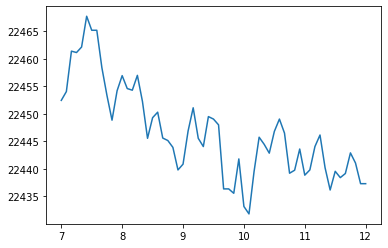

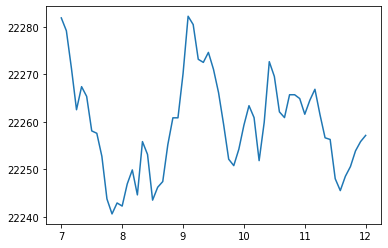

In [364]:
plt.plot(waves ,im1[150])
plt.show()
plt.plot(waves ,im2[150])
plt.show()


In [377]:
def importWaveData(index):
    filename = path + 'Capture'+str(index)+'.hdf5'
    try:
        with h5py.File(filename, "r") as file:
             r1 = np.mean(file['image1'][()], axis = 0)
             r2 = np.mean(file['image2'][()], axis = 0)
             t1 = np.mean(file['temp1'][()])
             t2 = np.mean(file['temp2'][()])
        im1 = pixel_registration(r1,cal_file1,waves,0,255)
        im2 = pixel_registration(r2,cal_file2,waves,0,255)
        err = 0         
    except:
        print(i)
        err = 1
       
    if err:
         return(err,"nan","nan","nan","nan")
    else: 
        return(err,t1,t2,im1,im2)

In [424]:
def generateSQLquery(index):
    err,t1,t2,im1,im2 = importWaveData(index)
    ims = [im1,im2];
    if err:
        print("file " + str(index) + "is corrupted")
    else :
        string = "INSERT INTO rawdata VALUES"
        for c in [1,2]:
            for w in range(len(waves)):
                for y in range(len(im1)):
                    string += '(' + str(index) + ', '
                    string += str(c)+ ', '
                    string += str(round(waves[w],2))+ ', '
                    string += str(y)+ ',' 
                    string += str(err)+ ','
                    string += str(round(ims[c-1][y,w]))+ '),'
                    
        return(string[:-1]+ ';')
                
            

In [425]:
import pandas as pd
from SQL import create_db_connection, execute_query
import matplotlib.pyplot as plt
import h5py
import datetime
import numpy as np

In [426]:
#user_info
pw = "p0larizati0n"
user = "root"
db = "IRCSP"

In [427]:
#connect to IRCSP database
connection = create_db_connection("localhost", user, pw, db)

MySQL Database connection successful


In [431]:
for index in range(2,2630):
    query = generateSQLquery(index);
    execute_query(connection, query)

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
2629
file 491is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
2629
file 950is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
2629
file 972is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
2629
file 991is corrupted
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Quer

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successful
Query successf

Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`ircsp`.`rawdata`, CONSTRAINT `rawdata_ibfk_1` FOREIGN KEY (`id`) REFERENCES `measurements` (`meas_id`))'
Error: '1452 (23000): Cannot a

Query successful
